In [1]:
%env MISTRAL_API_KEY=ZL4LdkeCwsoIYcNx2aFDujTYgpwj2kij
import os
import base64
import matplotlib.pyplot as plt
from mistralai import Mistral
import json
import pandas as pd
from typing import Union
import numpy as np
import secrets

pd.set_option('display.max_colwidth', None)
# Load Mistral API key from environment variables
api_key = os.environ["MISTRAL_API_KEY"]

# Model specification
model = "mistral-large-latest"

# Initialize the Mistral client
client = Mistral(api_key=api_key)

env: MISTRAL_API_KEY=ZL4LdkeCwsoIYcNx2aFDujTYgpwj2kij


In [2]:
def img_to_base64(image_path):
    """Input : image_path (str) : path to the image file
    Returns : image_base64 (str) : base64 encoded image"""
    
    with open(image_path, 'rb') as image_file:
        image_bytes = image_file.read()

    image_base64 = base64.b64encode(image_bytes).decode('utf-8')
    
    return image_base64

def json_to_dataframe(json_data: Union[str, dict], key: str = None) -> pd.DataFrame:
    # If json_data is a string, parse it into a dictionary
    if isinstance(json_data, str):
        json_data = json.loads(json_data)
    
    # If a key is provided, extract the list of records from the JSON object
    if key is not None:
        data = json_data[key]
    else:
        data = json_data
    
    # Convert the list of records to a pandas DataFrame
    df = pd.DataFrame(data)
    
    return df

def list_clothes(args): 
    image_base64, guide = args
    # Define the messages for the chat API
    messages = [
        {
            "role": "system",
            "content": "Return the answer in a JSON object with the next structure: "
                    "{\"elements\": [{\"element\": \"some name for element1\", "
                    "\"color\": \"the color of element1\", "
                    "\"fit\": \"the fit, shape of element1\", "
                    "\"price\": \"some number, estimated price of element1\", "
                    "\"context\": \"a word describing the occasion, mood or functionality of the piece\", "
                    "\"description\": \"a description of element1, emphasizing on the vibe of the piece and that encapsulates the precedent variables\"}, "
                    "{\"element\": \"some name for element2\", ...}]}"
        },
        {
            "role": "system",
            "content": f"You are a fashion critique, neutral and objective.\n\n {guide} \n\n You are presented with an image of an outfit, describe each of the elements thanks to your expertise "
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": f"data:image/jpeg;base64,{image_base64}"
                }
            ]
        }
    ]

    # Call the Mistral API to complete the chat
    chat_response = client.chat.complete(
        model="pixtral-12b-2409",
        messages=messages,
        temperature=0.4,
        response_format={
            "type": "json_object",
        }
    )

    # Get the content of the response
    content = chat_response.choices[0].message.content
    
    return content

def process_critique(args):
    outfit, guide = args
    
    chat_response = client.chat.complete(
        model="mistral-large-latest",
        messages=[
            {"role": "system", "content": "As a 'Fashion Critique', your mission is to help relook people. \n\n {guide} \n\n You are given a description of items in an outfit. Give a critique of the outfit, outlining the general vibe, how the pieces work together and what could be improved."},
            {"role": "user", "content": outfit},
        ],
        temperature=0.2,
        max_tokens=2048
    )
    result = chat_response.choices[0].message.content

    return result

def recommend_item(critique, guide, color_rule, piece_rule): 
    # Define the messages for the chat API
    messages = [
        {
            "role": "system",
            "content": "Return the answer in a JSON object with the next structure: "
                    "{\"elements\": [{\"element\": \"some short name for element1\", "
                    "\"color\": \"the color of element1\", "
                    "\"fit\": \"the fit, shape of element1\", "
                    "\"price\": \"some number, estimated price of element1\", "
                    "\"context\": \"a word describing the occasion, mood or functionality of the piece\", "
                    "\"description\": \"a description of element1, emphasizing on the vibe of the piece and that encapsulates the precedent variables\"}]}"
        },
        {
            "role": "system",
            "content": f"You are a fashion critique, neutral and objective.\n\n {guide} \n\n You are presented with a critique of an outfit, describe a single element that would improve the outfit."
        },
        {
            "role": "system",
            "content": "Follow this rule when suggesting a piece of clothing: " + piece_rule
        },
        {
            "role": "system",
            "content": "Follow this rule when choosing a color: " + color_rule
        },
        {
            "role": "user",
            "content": critique
        }
    ]

    # Call the Mistral API to complete the chat
    chat_response = client.chat.complete(
        model="mistral-large-latest",
        messages=messages,
        temperature=0.5,
        response_format={
            "type": "json_object",
        }
    )

    # Get the content of the response
    content = chat_response.choices[0].message.content
    
    return content

def save_df(clothes_df, reco_df):
    random_hash = secrets.token_hex(4)
    clothes_df.to_pickle(f"./data/clothes_{random_hash}.pkl")
    reco_df.to_pickle(f"./data/reco_{random_hash}.pkl")

def load_df(hash):
    clothes_df = pd.read_pickle(f"./data/clothes_{hash}.pkl")
    reco_df = pd.read_pickle(f"./data/reco_{hash}.pkl")
    
    return clothes_df, reco_df

In [11]:
desc_guide_path = "./desc_guide.txt"
critique_guide_path = "./critique_guide.txt"

with open(critique_guide_path, "rb") as f:
    critique_guide = f.read()

with open(desc_guide_path, "r") as f:
    desc_guide = f.read()

,element,color,fit,price,context,description
0,Navy Blazer,navy blue,"tailored, slim fit",approx. $300 - $500,business casual,"A tailored navy blazer with sharp shoulders and a slim waistline, exuding a refined and polished look ideal for business casual settings."
1,Blue Dress Shirt,blue,slim fit,approx. $100 - $200,business casual,"A slim-fit blue dress shirt that complements the navy blazer, providing a crisp and professional appearance suitable for business casual environments."
2,Burgundy Tie,burgundy,standard,approx. $50 - $100,business casual,"A burgundy tie that adds a touch of sophistication and warmth to the outfit, enhancing the overall professional yet approachable look."
3,Gray Wool Trousers,gray,slim fit,approx. $200 - $400,business casual,"Slim-fit gray wool trousers that provide a balanced contrast to the navy blazer, offering a polished and elegant base for the outfit."
4,Brown Leather Shoes,brown,standard,approx. $150 - $300,business casual,"Classic brown leather shoes that complete the ensemble with a touch of versatility and timeless style, perfect for business casual settings."


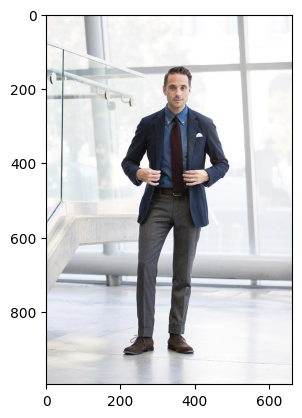

In [18]:
img_path = "test_images/img2.jpg"
plt.imshow(plt.imread(img_path))

img_64 = img_to_base64(img_path)
clothes = list_clothes((img_64, desc_guide))
clothes_df = json_to_dataframe(clothes, key='elements')
clothes_df

In [19]:
outfit = '-'+'\n-'.join(clothes_df['description'])
critique = process_critique((outfit, critique_guide))
print(critique)

**Outfit Critique:**

**General Vibe:** This outfit exudes a classic, professional, and polished vibe, perfect for business casual settings. It's refined, elegant, and gives off a confident and approachable air.

**What Works:**

1. **Color Palette:** The navy, blue, and gray combination is timeless and professional. The burgundy tie adds a warm and sophisticated pop of color, keeping the outfit interesting and not too monochromatic.

2. **Fit:** The tailored and slim-fit cuts of the blazer, shirt, and trousers create a clean, sharp silhouette that enhances the overall polished look.

3. **Balance:** The contrast between the navy blazer and gray trousers is well-balanced, creating a harmonious base for the outfit. The brown leather shoes add a touch of warmth and versatility, grounding the look.

**What Could Be Improved:**

1. **Accessories:** While the outfit is well-put-together, it could benefit from some subtle accessories to add personality and interest. Consider adding a pocket 

In [25]:
reco_df=[]
n_suggest = 3
color_rules = np.random.choice([ 
                          "complementary colors: colors that are opposite on the color wheel", 
                          "analogus colors: colors that are close on the color wheel", 
                          "accent color: one bright color that pops from the rest that are neutral", 
                          "sandwiching: layering a bright color between two neutral colors",
                          "monochromatic: using different shades of the same color to create a cohesive look",
                          "pattern mixing: combining different patterns to create a unique outfit",
                          "seasonal: using seasonal colors and pieces to create a weather-appropriate outfit",
                                    ], n_suggest, replace=False)
    
piece_rules = np.random.choice([
                            "mixing textures: incorporating different textures to add visual interest",
                            "statement piece: building an outfit around a bold statement piece",
                            "proportion balance: for example, baggy jeans with a skinny top", 
                            "accessories: adding an accessory to elevate the outfit",
                            "silouhette: creating a visually interesting shape with the outfit",
                            "jewelry: adding jewelry to elevate the outfit",
                            "replacement: suggesting a piece that would replace a current piece in the outfit",
                            "layering: adding a layer to the outfit to create depth, like a coat or jacket"
                                   ], n_suggest, replace=False)
for i in range(n_suggest):
    reco = recommend_item(critique, desc_guide, color_rules[i], piece_rules[i])  
    reco_df.append(json_to_dataframe(reco, key='elements'))

reco_df = pd.concat(reco_df,ignore_index=True)
reco_df

,element,color,fit,price,context,description
0,Pocket Square,Light Blue with Burgundy Pattern,N/A,25,Professional,"A light blue pocket square with a subtle burgundy pattern to complement the existing color palette and add a touch of elegance and personality to the outfit. This accessory will elevate the look, creating a more polished and put-together appearance."
1,Belt,Brown,"Adjustable, sleek buckle",50,Professional,"A sleek, adjustable brown leather belt with a polished buckle, designed to complement the shoes and create a more cohesive and refined business casual look."
2,Pocket Square,Light Blue or Patterned with Burgundy Accents,Folded neatly in the breast pocket,25,Professional,"A light blue or patterned pocket square with burgundy accents would complement the navy blazer and add a touch of personality and elegance to the outfit. It creates a visually interesting shape, drawing the eye to the chest and enhancing the overall silhouette. This subtle accessory elevates the look, making it more polished and memorable, perfect for a business casual setting."


In [17]:
save_df(clothes_df, reco_df)

In [44]:
clothes_df, reco_df = load_df("40ef0440")
reco_df


,element,color,fit,price,context,description
0,Pendant Necklace,Silver,Adjustable chain,50,Versatile,"A silver pendant necklace with a simple, elegant design. The adjustable chain allows for a customizable fit, making it a versatile addition to any outfit. The silver color complements the monochromatic theme of the existing pieces, while the pendant adds a touch of sophistication, elevating the overall look from casual to slightly more dressed up. This piece would help to tie the outfit together, adding a bit of shine and interest without overpowering the other elements."
1,Patterned Scarf,Mix of navy and white patterns,"Draped around the neck, adding volume to the upper body",25,Casual yet expressive,"A patterned scarf with a mix of navy and white patterns to complement the existing colors in the outfit. This scarf will be draped around the neck, adding volume to the upper body and creating a visually interesting shape with the outfit. The pattern mixing will create a unique and expressive look, enhancing the casual comfort of the white t-shirt and navy blue garment while adding a touch of personal style. Estimated price: $25."
2,Scarf,Mustard Yellow,Loose,25,Casual,"A mustard yellow scarf with a loose fit, adding a pop of color between the white t-shirt and navy blue garment, following the 'sandwiching' rule. This scarf elevates the outfit by enhancing the color palette and adding a casual, yet stylish accessory that complements the overall relaxed vibe."
